In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.windows import from_bounds
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import numpy as np
from patchify import patchify
import torch
from torch.functional import F
from torch import nn
from torch.utils.data import DataLoader
from shapely.geometry import box
from torchvision import transforms
import time
import random

from pytorch_segmentation.data.test_dataset import TestSatDataset
from pytorch_segmentation.models import UNet
import pytorch_segmentation.augmentation.transforms as seg_transforms

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
model_name = "unet_11_07_2022_070457"#"unet_05_05_2022_113034" #"unet_11_07_2022_070457"#"unet_13_07_2022_171256" 
data_parallel = True

save_dir = "saved_models"


data_file_path ="/home/jovyan/work/satellite_data/tmp/"
shape_path="/home/jovyan/work/notebooks/satellite_data/utils/shapes"
mask_path="/home/jovyan/work/notebooks/satellite_data/data/test_dataset"

test_patch_size = [256,256,3]
overlap_test = 128

batch_size = 50
nworkers = 10
pin_memory = True

padding = False#True

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
if str(device) == "cpu":
    pin_memory = False

test_transform = None

test_transform = seg_transforms.Compose([
    #seg_transforms.UnmaskEdges([225,225]),
     #seg_transforms.CLAHE_Norm(),
    #seg_transforms.Add_VDVI()
    ])

# 1.1 Data Collection

In [4]:
dataset = TestSatDataset(data_file_path =data_file_path,shape_path=shape_path,mask_path=mask_path,patch_size=test_patch_size,overlap=overlap_test,transform=test_transform,
                         resampling={2008:True,2009:True,2010:False,2011:True,2012:True,2013:False,2014:True},resampling_factor=6 )

Skipped shape due to nodata!
Size:  17046


In [5]:
test_dl = DataLoader(dataset,batch_size=batch_size,num_workers=nworkers,
                     shuffle=False,pin_memory=pin_memory,drop_last=False)

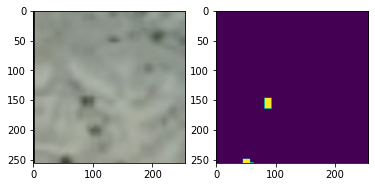

In [6]:
dataset.show_tuple(0)

# 2 Model

In [7]:
model_path = save_dir + "/" + model_name +  ".pth"
state_dict = torch.load(model_path,map_location="cpu")

In [8]:


if data_parallel:
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model_path = save_dir + "/" + model_name +  "_new.pth"
    torch.save(new_state_dict,model_path)
    

## 2.1 Advanced Unet

In [9]:
# Change here to adapt to your data
# n_channels=3 for RGB images 
# n_classes is the number of probabilities you want to get per pixel

net = UNet(n_channels=3, n_classes=2, bilinear=False)
#net= DataParallel(net)

if data_parallel:
    net.load_state_dict(new_state_dict)
else:
    net.load_state_dict(state_dict)
#net.load_state_dict(torch.load(model_path,map_location="cpu"))

net = net.to(device=device)



## 3 Validation

In [10]:
net.eval()
output = []
y_test = []

with torch.no_grad(): 
    for i,batch in enumerate(test_dl):
        x = batch["x"].to(device)
        out = net(x)#["out"]
        out = torch.argmax(out,dim=1)
        out = out.cpu().numpy()
        output.extend(out)
y_pred = torch.from_numpy(np.stack(output))

In [11]:
dataset.evaluate(y_pred)

Year 2008:          acc       iou      dice
0  0.938541  0.189366  0.290464
Year 2009:          acc       iou      dice
0  0.947391  0.255369  0.266488
Year 2010:          acc       iou      dice
0  0.968569  0.372067  0.438372
Year 2011:          acc       iou      dice
0  0.994101  0.768538  0.772354
Year 2012:         acc       iou     dice
0  0.98936  0.819027  0.82018
Year 2013:          acc       iou      dice
0  0.844659  0.280268  0.301455
Year 2014:          acc     iou      dice
0  0.965321  0.5552  0.560713
Total score:          acc       iou      dice
0  0.897134  0.448082  0.459208


,acc,iou,dice
0,0.897134,0.448082,0.459208


In [11]:
dataset.evaluate(y_pred)

Year 2008:          acc       iou      dice
0  0.956558  0.021805  0.041488
Year 2009:          acc       iou      dice
0  0.935311  0.166948  0.219038
Year 2010:          acc       iou      dice
0  0.968569  0.372067  0.438372
Year 2011:         acc      iou      dice
0  0.99407  0.60761  0.618099
Year 2012:          acc       iou      dice
0  0.985641  0.699419  0.704255
Year 2013:          acc       iou      dice
0  0.901952  0.304418  0.398757
Year 2014:          acc       iou      dice
0  0.995274  0.403363  0.406369
Total score:          acc       iou      dice
0  0.912109  0.395754  0.428722


,acc,iou,dice
0,0.912109,0.395754,0.428722


In [11]:
dataset.evaluate(y_pred)

Year 2008:          acc       iou      dice
0  0.956326  0.014227  0.026918
Year 2009:          acc       iou      dice
0  0.935684  0.163766  0.245337
Year 2010:          acc       iou      dice
0  0.966556  0.335502  0.388489
Year 2011:          acc       iou      dice
0  0.983479  0.547251  0.555629
Year 2012:          acc       iou     dice
0  0.993608  0.674545  0.67551
Year 2013:         acc       iou     dice
0  0.90293  0.324345  0.42211
Year 2014:          acc       iou      dice
0  0.993666  0.403197  0.406086
Total score:          acc       iou      dice
0  0.909535  0.372093  0.412595


,acc,iou,dice
0,0.909535,0.372093,0.412595
